# Classifies Chess Pieces

#Imports

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from google.colab.patches import cv2_imshow
%tensorflow_version 1.x
import torchvision.models as models
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torchvision.models as models
import torch
from collections import OrderedDict

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 1.x selected.
Mounted at /content/drive


# Dataset


#### Get Dataset

##### Turk Data

In [ ]:
foldername = "/content/drive/MyDrive/turk_data/data_done/"
dataset = pd.read_csv(foldername + 'my_csv.csv', names=['id','piece'])

##### Realsense

In [ ]:
foldername = "/content/drive/MyDrive/cv_chess_data/realsense_dataset0/"
dataset = pd.read_csv(foldername + 'my_csv.csv', names=['id','piece'])

In [ ]:
dataset.iloc[911]

id       f3067428159.jpg
piece                  0
Name: 911, dtype: object

In [ ]:
from torch.utils import data
dataset = dataset.drop([0,1, 911])
x = dataset.to_numpy()
for i in range(len(x)):
  x[i, 1] = int(x[i, 1])
dataset = pd.DataFrame(x, columns=['id','piece'])

#### Label Mapping

In [ ]:
piece_num_to_name = {
      0 : 'Empty',
      1 : 'Pawn',
      2 : 'Bishop',
      3 : 'Knight',
      4 : 'Rook',
      5 : 'Queen',
      6 : 'King'
}

#### Makes the dataset uniform

In [ ]:
def uniform(dataframe):
  dic = {}
  df = dataframe.sample(frac=1)
  for i in df['piece']:
    if i not in dic:
      dic[i] = dic.get(i, 0)
    else:
      dic[i] += 1
  min_key = min(dic, key=dic.get)
  minimum = dic.get(min_key)
  dic2 = {}
  new = pd.DataFrame(columns = ['id', 'piece'])
  for j in df['piece']:
    if j not in dic2:
      pholder = df.loc[df['piece']==j]
      pholder = pholder[:minimum]
      new = pd.concat([new,pholder], ignore_index=True)
      dic2[j] = dic2.get(j,0)
  return new

dataset = uniform(dataset)

#### Split Dataset Into Train, Validation, Test

In [ ]:
np.random.seed(123)


def data_split(N, ratio=[7, 2, 1]):
  shuffle_idx = np.arange(N)
  np.random.shuffle(shuffle_idx)
  data_split = (np.cumsum(ratio)/float(sum(ratio))*N).astype(int)
  out_idx = [None] * len(ratio)
  out_idx[0] = shuffle_idx[:data_split[0]]
  for i in range(1,len(ratio)):
    out_idx[i] = shuffle_idx[data_split[i-1] : data_split[i]]
  return out_idx  


split_idx = data_split(len(dataset))
df_train = dataset.loc[split_idx[0]]
df_valid = dataset.loc[split_idx[1]]
df_test = dataset.loc[split_idx[2]]

#### Create a Dataloader for each dataset

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, root_dir, df, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.file_names = df['id'].values
        self.targets = df['piece'].values
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        img_path = self.root_dir + self.file_names[index]
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(img)
        target = self.targets[index]
        return img, target


transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Grayscale(3)
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Grayscale(3)
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = ChessDataset(foldername, df_train, transforms=transform_train)
valid_dataset = ChessDataset(foldername, df_valid, transforms=transform_test)
test_dataset = ChessDataset(foldername, df_test, transforms=transform_test)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)  

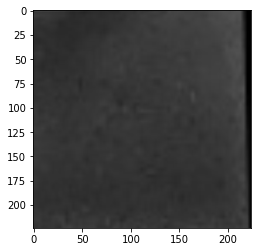

In [ ]:
x = train_dataset[5][0]

plt.imshow(x.permute(1, 2, 0))


# Model

#### Creates a Model

In [ ]:
model = models.vgg16()
classifier = torch.nn.Sequential(OrderedDict([('fc1', torch.nn.Linear(25088, 5000)),
                                        ('relu', torch.nn.ReLU()),
                                        ('drop', torch.nn.Dropout(p=0.5)),
                                        ('fc2', torch.nn.Linear(5000, 7)),
                                        ('output', torch.nn.LogSoftmax(dim=1))]))
model.classifier = classifier

#### Sets up GPU or CPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Using {device} device')

Using cpu device


#### Optimizer and Loss

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001, momentum=0.9)
model.to(device)

#### Fuction for Validation Pass

In [ ]:
def validation(model, validateloader, criterion):    
    val_loss = 0
    accuracy = 0
    for images, labels in iter(validateloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        val_loss += criterion(output, labels).item()
        probabilities = torch.exp(output)
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return val_loss, accuracy

#### Training the classifier

In [ ]:
def train_classifier():
        
        epochs = 30
        steps = 0
        print_every = 1
        model.to(device)
        for e in range(epochs):
            model.train()
            running_loss = 0
            for images, labels in iter(train_loader):
                steps += 1
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if steps % print_every == 0:
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, valid_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
            
                    running_loss = 0
                    model.train()
                    
train_classifier()                    

Epoch: 1/15..  Training Loss: 1.947..  Validation Loss: 1.945..  Validation Accuracy: 0.200
Epoch: 1/15..  Training Loss: 1.944..  Validation Loss: 1.945..  Validation Accuracy: 0.212
Epoch: 1/15..  Training Loss: 1.955..  Validation Loss: 1.945..  Validation Accuracy: 0.200
Epoch: 1/15..  Training Loss: 1.950..  Validation Loss: 1.946..  Validation Accuracy: 0.200
Epoch: 1/15..  Training Loss: 1.947..  Validation Loss: 1.946..  Validation Accuracy: 0.200
Epoch: 1/15..  Training Loss: 1.950..  Validation Loss: 1.946..  Validation Accuracy: 0.212
Epoch: 1/15..  Training Loss: 1.943..  Validation Loss: 1.946..  Validation Accuracy: 0.192
Epoch: 1/15..  Training Loss: 1.954..  Validation Loss: 1.946..  Validation Accuracy: 0.208
Epoch: 1/15..  Training Loss: 1.945..  Validation Loss: 1.946..  Validation Accuracy: 0.233
Epoch: 1/15..  Training Loss: 1.946..  Validation Loss: 1.946..  Validation Accuracy: 0.188
Epoch: 1/15..  Training Loss: 1.945..  Validation Loss: 1.946..  Validation Accu

#### Validation on Test Set

In [ ]:
def test_accuracy(model, test_loader):

    model.eval()
    model.to(device)
    with torch.no_grad():
        accuracy = 0
        for images, labels in iter(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
        print("Test Accuracy: {}".format(accuracy/len(valid_loader)))    
        
        
test_accuracy(model, test_loader)

NameError: ignored

#### Saving the Trained Model

In [ ]:
def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)    